In [1]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series
import math

In [69]:
k = 230 #W/m°C 
L = 0.050 #m
t = 0.02 #m
h = 210 #W/m²°C Convecção Forçada
T0 = 80 #°C
T_infinito = 25 #°C
w = 1 #m

In [70]:
meshx = 30
deltax = L/(meshx-0.5)

meshy = 30
deltay = t/(meshy-1)

In [71]:
#Solução exata 1D

x_plot = np.zeros(meshx)
y_plot = np.zeros(meshy)
T_exato = np.zeros(meshx)


x_plot[0] = deltax/2
for x in range(1,meshx):
    x_plot[x] = x_plot[x-1] + deltax
    
y_plot[0] = 0
for y in range(1,meshy):
    y_plot[y] = y_plot[y-1] + deltay
    

m= (2*h/(k*t))**0.5

eta = math.tanh(m*L)/(m*L)

for x in range(meshx):
    T_exato[x] = math.cosh(m*(L-x_plot[x]))/math.cosh(m*L) * (T0-T_infinito) + T_infinito
    
q_exato = (h*2*L*k*t*L)**0.5*(T0-T_infinito)*math.tanh(m*L)



In [72]:
eta

0.9302726070439278

In [73]:
#Numérico 2D
Matrix_coef_a = np.zeros((meshx*meshy,meshx*meshy))
Matrix_coef_b = np.zeros((meshx*meshy,1))
T=np.zeros((meshx*meshy,1))
ae = np.zeros((meshx,meshy))
aw = np.zeros((meshx,meshy))
an = np.zeros((meshx,meshy))
aS = np.zeros((meshx,meshy))
ap = np.zeros((meshx,meshy))
b = np.zeros((meshx,meshy))
 
for x in range(meshx):
    for y in range(meshy):
        #volume inferior esquerdo
        if (x == 0) and (y==0):
            aw[x,y] = 0
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = 0
            aw_f = k*(deltay/2)*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f
            b[x,y] = aw_f*T0
            
        #volume inferior direito
        if (x == 0) and (y==meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = 0
            an[x,y] = k*(deltax/2)*w/deltay
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
        #volume superior esquerdo
        if (x == meshx-1) and (y==0):
            aw[x,y] = 0
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = 0
            aS[x,y] = k*deltax*w/deltay
            an_f = h*deltax*w
            aw_f = k*(deltay/2)*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + an_f
            b[x,y] = aw_f*T0 + an_f*T_infinito
            
        #volume superior direito
        if (x == meshx-1) and (y==meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = 0
            an[x,y] = 0
            aS[x,y] = k*(deltax/2)*w/(deltay) 
            an_f = h*(deltax/2)*w
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes na face esquerda
        if (y == 0) and (x>0) and (x<meshx-1):
            aw[x,y] = 0
            ae[x,y] = k*deltay*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = k*deltax*w/deltay
            aw_f = k*deltay*w/(deltax/2)
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f
            b[x,y] = aw_f*T0
            
        #volumes na face direita
        if (y == meshy-1) and (x>0) and (x<meshx-1):
            aw[x,y] = k*deltay*w/deltax
            ae[x,y] = 0
            an[x,y] = k*(deltax/2)*w/deltay
            aS[x,y] = k*(deltax/2)*w/deltay            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0  
            
        #volumes no norte
        if (x == meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = 0
            aS[x,y] = k*deltax*w/deltay 
            an_f = h*deltax*w
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes no sul
        if (x == 0) and (y>0) and (y<meshy-1):
            aw[x,y] = k*(deltay/2)*w/deltax
            ae[x,y] = k*(deltay/2)*w/deltax
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
            
        #volumes internos
        if (x>0) and (x < meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = k*deltay*w/deltax
            ae[x,y] = aw[x,y]
            an[x,y] = k*deltax*w/deltay
            aS[x,y] = an[x,y]            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
                     
#montando a matriz de coeficientes:
cont = 0
for x in range(meshx):
    for y in range(meshy):
        Matrix_coef_a[cont,cont] = ap[x,y]
        Matrix_coef_a[cont,cont-1] = -aw[x,y]
        
        if cont < meshx*meshy-1:
            Matrix_coef_a[cont,cont+1] = -ae[x,y]
        if cont < meshx*meshy-meshy:   
            Matrix_coef_a[cont,cont+meshy] = -an[x,y]
        if cont >meshy-1:
            Matrix_coef_a[cont,cont-meshy] = -aS[x,y]
        
        
        Matrix_coef_b[cont,0] = b[x,y]
        cont += 1
        
    
T = solve(Matrix_coef_a,Matrix_coef_b)


In [74]:
T_plot

array([[ 79.97684077,  79.93059593,  79.88457148,  79.83891286,
         79.79376339,  79.74926338,  79.70554945,  79.66275387,
         79.62100394,  79.58042153,  79.54112267,  79.50321728,
         79.46680887,  79.4319945 ,  79.39886463,  79.36750319,
         79.33798757,  79.3103888 ,  79.2847716 ,  79.26119461,
         79.23971052,  79.2203663 ,  79.20320335,  79.18825772,
         79.17556024,  79.16513673,  79.15700811,  79.1511905 ,
         79.14769537,  79.14652957],
       [ 79.97680269,  79.93048191,  79.88438219,  79.83864944,
         79.79342736,  79.74885667,  79.70507431,  79.66221286,
         79.62039987,  79.57975743,  79.54040171,  79.50244275,
         79.46598414,  79.43112295,  79.39794967,  79.36654817,
         79.33699582,  79.30936355,  79.28371602,  79.26011176,
         79.23860337,  79.21923773,  79.20205614,  79.18709455,
         79.17438372,  79.16394939,  79.15581241,  79.14998887,
         79.1464902 ,  79.14532322],
       [ 79.9766882 ,  79.9301

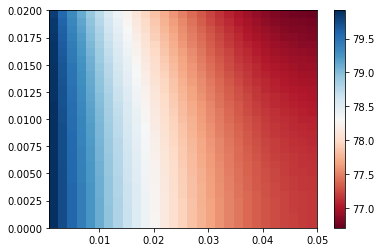

In [75]:
%matplotlib inline
T_plot = np.zeros((meshx,meshy))

#transformando o vetor Temperatura em Matriz

cont = 0
for x in range(meshx):
    for y in range(meshy):
        T_plot[x,y] = T[cont]
        cont += 1
        
X,Y = np.meshgrid(x_plot,y_plot)

fig, ax = plt.subplots()

#ax.contourf(X,Y,T_plot,200,'linestyle')
p = ax.pcolor(X, Y, T_plot, cmap=plt.cm.RdBu, vmin=abs(T_plot).min(), vmax=abs(T_plot).max())
cb = fig.colorbar(p, ax=ax)

